In [77]:
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon , MultiPolygon
import geopandas as gpd
import matplotlib.pyplot as plt

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        Get census tracts and community areas from the city of chicago data portal
</span>
<hr style="color: #8EB944; height: 1px;background-color: #43556A;border: none">

In [158]:
census = gpd.read_file('Boundaries.geojson')
comm_area = gpd.read_file('comm_area.geojson')

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        1. Get Locations of Bars and Night Clubs in Chicago
</span>
<hr style="color: #8EB944; height: 1px;background-color: #43556A;border: none">

Go the city of chicago portal and look up the dataset containing all small business licenses from 2002 to now: https://data.cityofchicago.org/Community-Economic-Development/Business-Licenses/r5kz-chrr/data.

Filter out all the licenses that expired before 01/01/2019 or were granted after the 01/01/2020, additioanally filter out all the samples without a valid location. 

To find the bars and night clubs, we take a look at the LICENSE DESCRIPTION column and check the unique values. We find that the values 'Late Hour', 'Music and Dance' and 'Tavern' corresponds to bars or night clubs or business that have a liquor license for nights. Applying these filter, we get 1669 bars or night clubs that had a valid business license in 2019.

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        2. Clean the bar/night club data 
</span>
<hr style="color: #8EB944; height: 1px;background-color: #43556A;border: none">

In [159]:
# load the dataset and keep a subset of the columns
bar_club = pd.read_csv('Bus_licenses.csv')[['DOING BUSINESS AS NAME','ADDRESS','LICENSE DESCRIPTION',
                                               'BUSINESS ACTIVITY','LONGITUDE','LATITUDE' ]]
# take a look at the data
bar_club.head()

,DOING BUSINESS AS NAME,ADDRESS,LICENSE DESCRIPTION,BUSINESS ACTIVITY,LONGITUDE,LATITUDE
0,FIRESIDE TAVERN AND GRILL,5739-5741 N RAVENSWOOD AVE 1ST,Late Hour,"Sale of Liquor Until 4am, Monday - Saturday an...",-87.674541,41.986231
1,FIRESIDE TAVERN AND GRILL,5739-5741 N RAVENSWOOD AVE 1ST,Late Hour,"Sale of Liquor Until 4am, Monday - Saturday an...",-87.674541,41.986231
2,Gold Coast Social,7 W DIVISION ST 1,Late Hour,"Sale of Liquor Until 4am, Monday - Saturday an...",-87.628992,41.903827
3,2Bears Tavern Uptown,1140 W WILSON AVE,Late Hour,"Sale of Liquor Until 4am, Monday - Saturday an...",-87.659159,41.965489
4,2Bears Tavern Uptown,1140 W WILSON AVE,Late Hour,"Sale of Liquor Until 4am, Monday - Saturday an...",-87.659159,41.965489


Create a new category column. We cannot perfectly distinguish between bars and nightclubs, thus we decide to call the category bar/night club. Also we rename the other columns to match the format of our other POI data.
Additionally, we drop the License Description and Business Activity and Doing Business as Name, because they are not needed later on.

In [160]:
bar_club['Category'] = 'Bar/ Night Club'
bar_club.drop(columns = ['BUSINESS ACTIVITY', 'LICENSE DESCRIPTION', 'DOING BUSINESS AS NAME' ], inplace = True)
bar_club.rename(columns = {'ADDRESS': 'Address', 'LONGITUDE': 'Longitude',
                          'LATITUDE': 'Latitude'}, inplace = True)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
         3. Drop out all the duplicate bars/clubs

In [161]:
bar_club.drop_duplicates(subset='Longitude', inplace = True)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        4. Get locations for sport stadiums and airports from google maps
</span>
<hr style="color: #8EB944; height: 1px;background-color: #43556A;border: none">

As the business license dataset does not contain licenses for sport stadiums and airports, we scrape them from google maps using mapscraper (https://mapsscraper.com).
We argue that airport and large sport events like NBA games attract people from out of town that would take a taxi.

In [162]:
# load the datasets that were scraped from google maps.
airports = pd.read_csv('mapsscraper.csv')
stadiums = pd.read_csv('mapsscraper (2).csv')

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        5. Clean the data
</span>
<hr style="color: #8EB944; height: 1px;background-color: #43556A;border: none">

In [163]:
# merge the two datasets and keep a subset of the columns
airp_stad = pd.concat([airports, stadiums])[['Address','Longitude','Latitude','Category']]

In [164]:
categories = airp_stad.Category.unique()
categ_map = {}

# Iterate over each category in the list
for category in categories:
    if 'airport' in category.lower():
        categ_map[category] = 'Airport'
        
    elif 'stadium' in category.lower()  or \
         'baseball' in category.lower()  :
        categ_map[category] = 'Stadium'

    else:
        categ_map[category] = np.nan

In [165]:
airp_stad.Category = airp_stad.Category.apply(lambda x: categ_map[x])

In [166]:
airp_stad = airp_stad[airp_stad.Category.notna()]

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        6. Get Hotel Locations from the City of Chicago Data Portal
</span>
<hr style="color: #8EB944; height: 1px;background-color: #43556A;border: none">
<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        6.1 Load the dataset

In [167]:
hotels = pd.read_csv('chic_hotels.csv')[
        ['DOING BUSINESS AS NAME', 'ADDRESS', 'LICENSE TERM START DATE', 'LICENSE DESCRIPTION',
         'LICENSE TERM EXPIRATION DATE',  'LONGITUDE', 'LATITUDE']]

In [168]:
hotels.head()

,DOING BUSINESS AS NAME,ADDRESS,LICENSE TERM START DATE,LICENSE DESCRIPTION,LICENSE TERM EXPIRATION DATE,LONGITUDE,LATITUDE
0,RED ROOF INNS #281,162 E ONTARIO ST,03/16/2017,Regulated Business License,03/15/2019,-87.622894,41.893469
1,Inn at LIncoln Park,601 W DIVERSEY PKWY 1ST,04/16/2019,Regulated Business License,07/15/2021,-87.643671,41.932715
2,Inn at LIncoln Park,601 W DIVERSEY PKWY 1ST,04/16/2017,Regulated Business License,04/15/2019,-87.643671,41.932715
3,SOHO HOUSE CHICAGO,113-125 N GREEN ST BSMT - 6TH,06/16/2018,Regulated Business License,07/15/2020,-87.648432,41.883557
4,FREEHAND CHICAGO / CAFE INTEGRAL / BROKEN SHAKER,17-19 E OHIO ST 1-17,05/16/2019,Regulated Business License,07/15/2021,-87.627329,41.892372


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        6.2 Format the data

In [169]:
hotels['Category'] = 'Hotel'
hotels.drop(columns = ['LICENSE DESCRIPTION', 'DOING BUSINESS AS NAME',
                        'LICENSE TERM START DATE', 'LICENSE TERM EXPIRATION DATE'], inplace = True)
hotels.rename(columns = {'ADDRESS': 'Address', 'LONGITUDE': 'Longitude',
                          'LATITUDE': 'Latitude'}, inplace = True)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        6.3 Drop out all the duplicate locations

In [170]:
hotels.drop_duplicates(subset='Longitude', inplace = True)

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        6. Merge the 3 datasets
</span>
<hr style="color: #8EB944; height: 1px;background-color: #43556A;border: none">

In [171]:
poi_data = pd.concat([bar_club, airp_stad,hotels])

In [176]:
poi_data.head()

,Address,Longitude,Latitude,Category
0,5739-5741 N RAVENSWOOD AVE 1ST,-87.674541,41.986231,Bar/ Night Club
2,7 W DIVISION ST 1,-87.628992,41.903827,Bar/ Night Club
3,1140 W WILSON AVE,-87.659159,41.965489,Bar/ Night Club
5,1332 N HALSTED ST 1ST/M,-87.648292,41.906038,Bar/ Night Club
6,5338 N LINCOLN AVE 1,-87.692789,41.978854,Bar/ Night Club


<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        7. Filter out the locations that are outside of the city
</span>
<hr style="color: #8EB944; height: 1px;background-color: #43556A;border: none">
<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        1. Create point objects from the gps data

In [177]:
poi_data['Location'] = [Point(xy) for xy in zip(poi_data['Longitude'], poi_data['Latitude'])]

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        2. Create a GeoDataFrame

In [178]:
geo_poi = gpd.GeoDataFrame(poi_data, geometry = 'Location', crs = "EPSG:4326")

<span style ="font-size: 18px; font-weight: bold;color: #43556A;">
        3. Filter out all the locations outside of chicago

Getting the area of the city by creating a single multipolygon with the unary_union method. To do so, dissolve the interior boundaries of the community areas first. The community areas were downloaded from the city of chicago data portal

In [179]:
boundary_polygon = comm_area.dissolve().unary_union  

# Filter out all points that do not lie within the boundary polygon
geo_poi = geo_poi[geo_poi.within(boundary_polygon)]

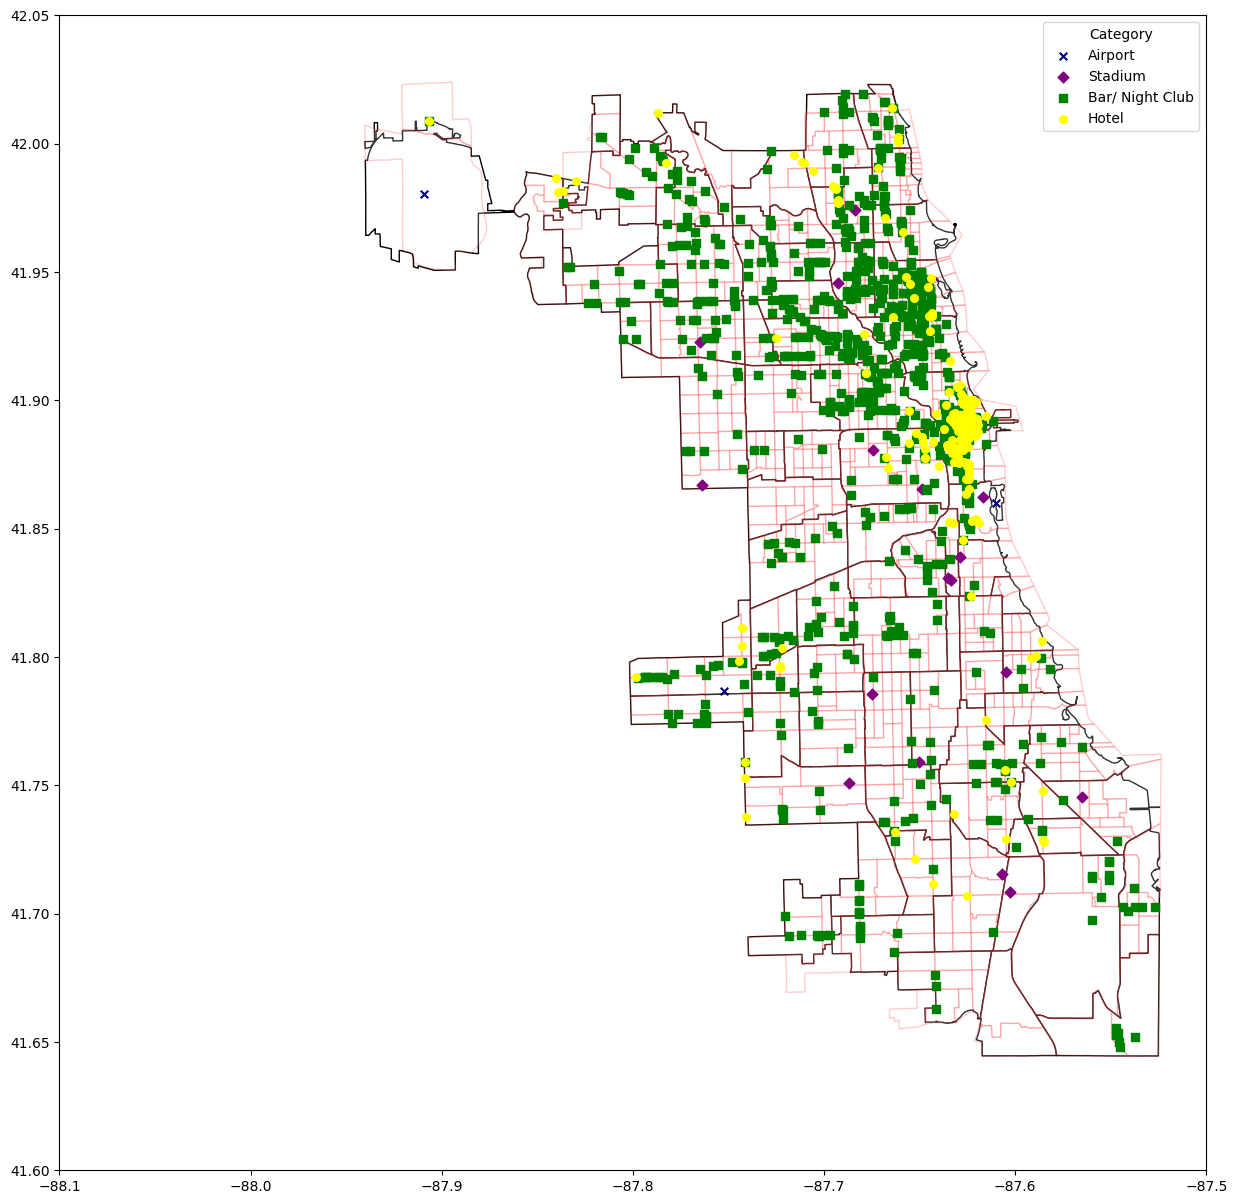

In [181]:
markers = {'Airport': 'x', 'Stadium': 'D', 'Bar/ Night Club': 's',
          'Hotel':'o'}

colors = {'Airport': 'navy',  'Stadium': 'purple', 'Bar/ Night Club': 'green',
         'Hotel':'yellow'}



base = comm_area.plot(color='white', edgecolor='black', figsize=(15, 15))
census.plot(ax=base, color='white', edgecolor='red',alpha=0.2)


for category, marker in markers.items():
    subset = geo_poi[geo_poi['Category'] == category]
    subset.plot(ax=base, marker=marker,color=colors[category], label=category, markersize=30)


# Set the x and y limits to zoom in on the region of interest
base.set_xlim([-88.1, -87.5])  # Adjust these limits as needed
base.set_ylim([41.6, 42.05]) 

plt.legend(title= 'Category')

#plt.savefig('poi.png')

In [182]:
geo_poi.to_file('POI_data.geojson')